# import

In [207]:
import pandas as pd
import numpy as np
import random
import os
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
# import torch.nn.functional as F # 비선형석 첨가
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm


from matplotlib import font_manager,rc
rc('font', family='AppleGothic')
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings(action='ignore')

# Data 불러오기

In [208]:
train_df = pd.read_pickle('./processed_data/train_df_dl.pkl')
test_df = pd.read_pickle('./processed_data/test_df_dl.pkl')

display(train_df)
display(test_df)

# Fixed Random Seed

In [209]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = True

seed_everything(42) # Seed 고정

# Hyperparameter Setting

In [210]:
# 하이퍼파라미터
input_size = 30  # feature의 개수
hidden_size = 64 # LSTM 레이어의 으닉 상태의 크기
num_layers = 2 # 학습 모델을 직렬 배치할 개수
output_size = 1 # 결과 값 형태
num_epochs = 5 # 학습 횟수
window_size = 24  # 예측에 사용될 시간 윈도우 크기, 예측을 위해 이전 몇개의 데이터 포인트를 참고할 것인가, 직전 24시간 데이터를 기반으로 다음 시간을 예측한다.
batch_size = 64 # 학습시 한번에 들어가는 input 데이터 개수 24 * 64개 가 한번에 학습 들어간다. batch_size가 커지면 기울기 업데이트 보편적인 학습이되고 업데이트 횟수는 줄어든다. 모델의 일반화 성능이 올라감
learning_rate = 0.001 

In [211]:
# input_size = len(['temperature', 'windspeed', 'humidity', 'year', 'month', 'day', 'hour', 'day_of_week', 'WCT', 'THI', 'holiday', 'total_area', 'cooling_area',
#               'rainfall', 'solar_power_capacity', 'ess_capacity', 'pcs_capacity', 'building_type_Apartment', 'building_type_Commercial', 'building_type_Data_Center',
#               'building_type_Department_Store_and_Outlet', 'building_type_Discount_Mart', 'building_type_Hospital', 'building_type_Hotel_and_Resort',
#               'building_type_Knowledge_Industry_Center', 'building_type_Other_Buildings', 'building_type_Public', 'building_type_Research_Institute',
#               'building_type_University', 'power_consumption'])

# Dataset

In [212]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, window_size):
        self.df = df
        self.window_size = window_size

    def __len__(self): # row의 길이 반환
        return len(self.df) - self.window_size

    def __getitem__(self, idx): # dataset의 indexing
        x = torch.tensor(self.df[idx:idx+self.window_size, :], dtype=torch.float)
        if self.df.shape[1] > 1:
            y = torch.tensor(self.df[idx+self.window_size, -1], dtype=torch.float)
        else:
            y = None
        return x, y

def create_data_loader(df, window_size, batch_size):
    dataset = TimeSeriesDataset(df, window_size)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return data_loader

In [213]:
# OneHotEncoder 객체 생성
encoder = OneHotEncoder()

# '색상' 컬럼을 원-핫 인코딩
encoded_data_train = encoder.fit_transform(train_df[['building_type']])
encoded_data_test = encoder.transform(test_df[['building_type']])

# 인코딩 결과를 데이터프레임으로 변환
df_encoded_train = pd.DataFrame(encoded_data_train.toarray(), columns=encoder.get_feature_names_out(['building_type']))
df_encoded_test = pd.DataFrame(encoded_data_test.toarray(), columns=encoder.get_feature_names_out(['building_type']))

train_df = pd.concat([train_df, df_encoded_train],axis=1)
test_df = pd.concat([test_df, df_encoded_test],axis=1)

temp = train_df.pop('power_consumption')
train_df['power_consumption'] = temp
train_df = train_df.drop(columns='building_type')
test_df = test_df.drop(columns='building_type')

train_df.columns, test_df.columns


In [214]:
# normalization
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_df.drop(['num_date_time', 'building_number', 'date_time', 'day_of_year'], axis=1).values)
train_loader = create_data_loader(train_data, window_size, batch_size)

# Model Define

In [215]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0)) # h : 은닉상태, c: 메모리셀 기억층(네부에서만 사용), # - 는 히드 스테이트 나오는거
        out = self.fc(out[:, -1, :]) 
        
        return out

In [216]:
# 맥 실리콘 사용을 위한 디바이스 이동
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
print(f"current device: {device}")

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # 최적화 방식

# Train

In [217]:
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).to(device)

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 300 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))
            
print('==================== 학습 완료 ====================')

# Test Data Pre-processing

In [218]:
# 학습 데이터에서 마지막 행 가져오기
last_train_data = train_df.drop(['num_date_time', 'building_number', 'date_time', 'day_of_year'], axis=1).loc[204000-24:,:]

# 전력소비량 열 생성
final_df = pd.concat((test_df.drop(['num_date_time', 'building_number', 'date_time', 'day_of_year'], axis=1), pd.DataFrame(np.zeros(test_df.shape[0]))),axis=1)
final_df = final_df.rename({0:'power_consumption'},axis=1)

# Test Dataset

In [219]:
test_df = pd.concat((last_train_data, final_df)).reset_index(drop=True)
test_data = scaler.transform(test_df.values) # train과 동일하게 scaling
test_data.shape

In [220]:
# Dataset & DataLoader
test_dataset = TimeSeriesDataset(test_data, window_size)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Inference

In [ ]:
model.eval()

test_predictions = []

with torch.no_grad():
    for i in tqdm(range(test_data.shape[0] - window_size)):
        x = torch.Tensor(test_data[i:i+window_size,:]).to(device)
        new_x = model(x.view(1,window_size,-1))
        
        test_data[i+window_size,-1] = new_x # 입력 업데이트
        test_predictions.append(new_x.detach().cpu().numpy().item()) # 예측 결과 저장

# Submit

In [ ]:
predictions = scaler.inverse_transform(test_data)[24:,-1] # 원래 scale로 복구

In [ ]:
sample_submission = pd.read_csv('./input/sample_submission.csv')

In [ ]:
sample_submission['answer'] = predictions
sample_submission.head()

In [ ]:
current_time = datetime.now()
formatted_time = current_time.strftime("%Y%m%d_%H%M%S")
sample_submission.to_csv(f'./result/{formatted_time}_lstm_baseline_submission.csv', index=False)

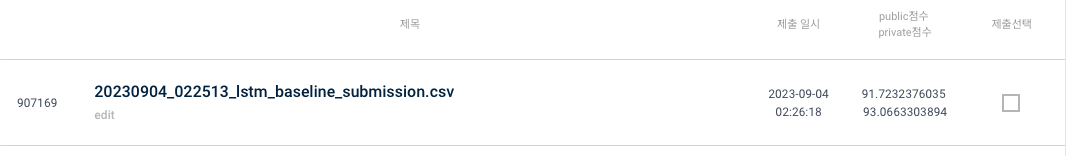

# 결과 시각화

In [ ]:
train_df = pd.read_pickle('./processed_data/train_df_dl.pkl')
test_df = pd.read_pickle('./processed_data/test_df_dl.pkl')

In [ ]:
test_df['power_consumption'] = sample_submission['answer']
final_df = pd.concat([train_df, test_df])
final_df.reset_index(drop=True)

In [ ]:
# final_df.groupby('day_of_year').power_consumption.mean().tail(60)

In [ ]:
모든_건물의_전기사용량_일자별_총합 = final_df.groupby('day_of_year').power_consumption.sum()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(모든_건물의_전기사용량_일자별_평균.index,모든_건물의_전기사용량_일자별_총합.values)
plt.title('날자별_모든_건물의_전기사용량_평균')
plt.xlabel('Day of the Year')
plt.ylabel('모든_건물의_전기사용량_일자별_평균(kWh)')
plt.show()

In [ ]:
날자별_ = final_df.groupby(by='day_of_year').power_consumption.mean()

plt.figure(figsize=(10, 6))
plt.plot(final_df.groupby('day_of_year').power_consumption.mean().index, final_df.power_consumption)
plt.title('Mean Power Consumption by Day of the Year')
plt.xlabel('Day of the Year')
plt.ylabel('모든_건물의_전기사용량_일자별_평균(kWh)')
plt.show()
